## Logistic regression and DT model to predict click-rate on the add

### In this problem, the task is to predict click probability i.e. probability of user clicking the ad which is shown to them on the partner websites for the next 7 days on the basis of historical view log data, ad impression data and user data.

### Train data contains the impression logs during 2018/11/15 – 2018/12/13 along with the label which specifies whether the ad is clicked or not. Your model will be evaluated on the test data which have impression logs during 2018/12/12 – 2018/12/18 without the labels.

In [0]:
import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd               
import numpy as np
import pickle


from sklearn.linear_model import LinearRegression         #linear regression
from sklearn.metrics.regression import mean_squared_error #error metrics
from sklearn.metrics import mean_absolute_error

import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation

%matplotlib inline     
sns.set(color_codes=True)

In [0]:
# Read data through Pandas and compute time taken to read

t_start = time.time()
train = pd.read_csv('train.csv')
t_end = time.time()
print('pd.read_csv(): {} s'.format(t_end-t_start)) # time [s]
train.head()

pd.read_csv(): 0.38570261001586914 s


,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [0]:
t_start = time.time()
test = pd.read_csv('test.csv')
t_end = time.time()
print('pd.read_csv(): {} s'.format(t_end-t_start)) # time [s]
train.head()

pd.read_csv(): 0.14452385902404785 s


,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
impression_id      237609 non-null object
impression_time    237609 non-null object
user_id            237609 non-null int64
app_code           237609 non-null int64
os_version         237609 non-null object
is_4G              237609 non-null int64
is_click           237609 non-null int64
dtypes: int64(4), object(3)
memory usage: 12.7+ MB


In [0]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,237609.0,46454.526828,26802.726666,0.0,23197.0,46597.0,69684.0,92586.0
app_code,237609.0,249.099971,135.213609,0.0,163.0,213.0,385.0,522.0
is_4G,237609.0,0.361312,0.480382,0.0,0.0,0.0,1.0,1.0
is_click,237609.0,0.045714,0.208864,0.0,0.0,0.0,0.0,1.0


In [0]:
train.shape

(237609, 7)

In [0]:
#Perform Pandas profiling to understand quick overview of columns

import pandas_profiling as pp
report = pp.ProfileReport(train)
#covert profile report as html file
report.to_file("click-rate_data.html")

In [0]:
from IPython.display import display,HTML,IFrame

display(HTML(open('click-rate_data.html').read()))

Number of variables,7
Number of observations,237609
Total Missing (%),0.0%
Total size in memory,12.7 MiB
Average record size in memory,56.0 B
Numeric,2
Categorical,2
Boolean,2
Date,0
Text (Unique),1
Rejected,0


#### is_click is click rate(Target) _Whether user clicked the AD (1-click, 0-no click)

In [0]:
# count the number of NaN values in each column
print(train.isnull().sum())

impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
is_click           0
dtype: int64


In [0]:
# Lets plot the correlation matrix 

corr_matrix = train.corr()
corr_matrix

,user_id,app_code,is_4G,is_click
user_id,1.000000,0.000247,0.000256,-0.001035
app_code,0.000247,1.000000,-0.081480,-0.005449
is_4G,0.000256,-0.081480,1.000000,-0.003464
is_click,-0.001035,-0.005449,-0.003464,1.000000


## Visualizing the features

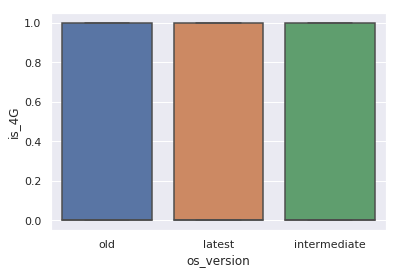

In [0]:
sns.boxplot(x='os_version', y='is_4G', data=train)
plt.show()

In [0]:
# Relation between is_4G and is_click

pd.crosstab(train['is_4G'], train['is_click'], rownames=['is_4G'], colnames=['is_click'])

is_click,0,1
is_4G,,
0,144738,7020
1,82009,3842


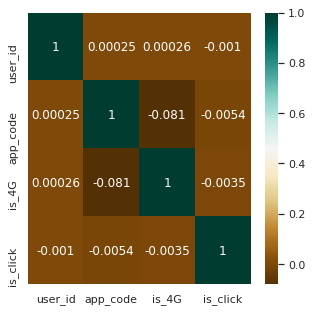

In [0]:
plt.figure(figsize=(5,5))
c = train.corr()
sns.heatmap(c,cmap="BrBG",annot=True)


#### Convert Categorical to Numerical for os_version column

os_version_1 = Latest
os_version_2 = Old


In [0]:
os_version_encoded = pd.get_dummies(train['os_version'], drop_first=True, prefix = 'os_version')
os_version_encoded.head()

,os_version_latest,os_version_old
0,0,1
1,1,0
2,0,0
3,1,0
4,1,0


In [0]:
os_version_encoded = pd.get_dummies(test['os_version'], drop_first=True, prefix = 'os_version')
os_version_encoded.head()

,os_version_latest,os_version_old
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [0]:
df= pd.concat([train, os_version_encoded] ,axis=1)
df.shape

(237609, 9)

In [0]:
df_test= pd.concat([test, os_version_encoded] ,axis=1)
df_test.shape

(90675, 8)

In [0]:
df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,os_version_latest,os_version_old
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,1
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,0,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,0


In [0]:
df['impression_time']=pd.to_datetime(df['impression_time'], errors='coerce')
df['Hour']=df['impression_time'].dt.hour
df['Month']=df['impression_time'].dt.month
df['day']=df['impression_time'].dt.dayofweek
df['Minute']=df['impression_time'].dt.minute
df['Second']=df['impression_time'].dt.second


In [0]:
df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,os_version_latest,os_version_old,Hour,Month,day,Minute,Second
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,1,0,11,3,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,0,0,11,3,1,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,0,0,0,11,3,2,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,0,0,11,3,2,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,0,0,11,3,2,0


In [0]:
df.shape

(237609, 14)

In [0]:
df['impression_id'] = df['impression_id'].str.extract('(\d+)', expand=False)


In [0]:
df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,os_version_latest,os_version_old,Hour,Month,day,Minute,Second
0,4,2018-11-15 00:00:00,87862,422,old,0,0,0,1,0,11,3,0,0
1,45,2018-11-15 00:01:00,63410,467,latest,1,1,1,0,0,11,3,1,0
2,70,2018-11-15 00:02:00,71748,259,intermediate,1,0,0,0,0,11,3,2,0
3,8,2018-11-15 00:02:00,69209,244,latest,1,0,1,0,0,11,3,2,0
4,182,2018-11-15 00:02:00,62873,473,latest,0,0,1,0,0,11,3,2,0


In [0]:
df_test['impression_time']=pd.to_datetime(df_test['impression_time'], errors='coerce')
df_test['Hour']=df_test['impression_time'].dt.hour
df_test['Month']=df_test['impression_time'].dt.month
df_test['day']=df_test['impression_time'].dt.dayofweek
df_test['Minute']=df_test['impression_time'].dt.minute
df_test['Second']=df_test['impression_time'].dt.second

In [0]:
df_test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,os_version_latest,os_version_old,Hour,Month,day,Minute,Second
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,1,0,7,12,3,44,0
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,1,0,7,12,3,45,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1,1,0,7,12,3,46,0
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1,1,0,7,12,3,47,0
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1,1,0,7,12,3,48,0


In [0]:
y_train = df['is_click']

In [0]:
y_train.value_counts()

0    226747
1     10862
Name: is_click, dtype: int64

In [0]:
# Lets separate the categorical columns from train data

X=df.drop(["os_version", "is_click", 'impression_time','impression_id'], axis=1)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

# Scale and center the data
X_train = scaler.transform(X)

# Create a pandas DataFrame
X_train = pd.DataFrame(data=X, index=X.index, columns=X.columns)


In [0]:
X_train.shape

(237609, 10)

In [0]:
X_train.head()

,user_id,app_code,is_4G,os_version_latest,os_version_old,Hour,Month,day,Minute,Second
0,87862,422,0,0,1,0,11,3,0,0
1,63410,467,1,1,0,0,11,3,1,0
2,71748,259,1,0,0,0,11,3,2,0
3,69209,244,1,1,0,0,11,3,2,0
4,62873,473,0,1,0,0,11,3,2,0


In [0]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 10 columns):
user_id              237609 non-null int64
app_code             237609 non-null int64
is_4G                237609 non-null int64
os_version_latest    237609 non-null uint8
os_version_old       237609 non-null uint8
Hour                 237609 non-null int64
Month                237609 non-null int64
day                  237609 non-null int64
Minute               237609 non-null int64
Second               237609 non-null int64
dtypes: int64(8), uint8(2)
memory usage: 15.0 MB


In [0]:
# Lets separate the categorical columns from test data

Xt=df_test.drop(["os_version", 'impression_time','impression_id'], axis=1)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xt)

# Scale and center the data
X_test = scaler.transform(Xt)

# Create a pandas DataFrame
X_test = pd.DataFrame(data=Xt, index=Xt.index, columns=Xt.columns)

In [0]:
X_test.head()

,user_id,app_code,is_4G,os_version_latest,os_version_old,Hour,Month,day,Minute,Second
0,44754,127,1,1,0,7,12,3,44,0
1,29656,44,0,1,0,7,12,3,45,0
2,25234,296,1,1,0,7,12,3,46,0
3,22988,207,1,1,0,7,12,3,47,0
4,35431,242,1,1,0,7,12,3,48,0


In [0]:
X_test.shape

(90675, 10)

### Model building

## Train the model

In [0]:

# Building the Logistic Regression Model

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1, n_jobs=1)               # Set Large C value for low regularization to prevent overfitting
logreg.fit(X_train, y_train)

print(logreg.coef_)                                            # Coefficients for Logistic Regression
print(logreg.intercept_)

[[-2.44376297e-07 -1.82544109e-04 -1.30787356e-02 -2.93983945e-02
  -1.10858355e-05  3.63219652e-03 -2.61893153e-01 -9.33101574e-03
   1.09324807e-03  0.00000000e+00]]
[-0.02459261]


In [0]:
# now applying our learnt model on test and also on train data

y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

In [0]:
# comparing the metrics of predicted lebel and real label of test data
print("Train Accuracy: ", metrics.accuracy_score(y_train, y_pred_train))

Train Accuracy:  0.9542862433662025


### train data accuracy is 95.42%

In [0]:
#predict on train data
y_pred_train = model_fit.predict(X_train)

#mean squared error
mse=mean_squared_error(y_train,y_pred_train)

#root mean squared error
print('train rmse: {}'.format(np.sqrt(mse)))

#mean absolute error
mae=mean_absolute_error(y_train,y_pred_train)
print('train mae: {}'.format(mae))

train rmse: 0.2124353124074949
train mae: 0.045128761957669954


In [0]:
#Check model's accuracy
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_pred_train)

0.5098169544453459

In [0]:
cm=metrics.confusion_matrix(y_train, y_pred_train)
cm

array([[226669,     78],
       [ 10645,    217]])

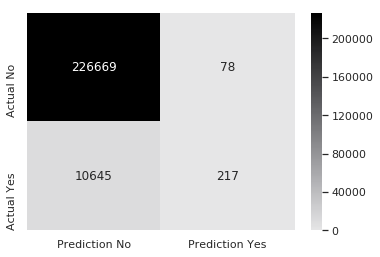

In [0]:
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm,cmap = cmap,xticklabels=['Prediction No','Prediction Yes'],yticklabels=['Actual No','Actual Yes'], annot=True,
            fmt='d')

In [0]:
# Creating Classification Report

cr = metrics.classification_report(y_train, y_pred_train)
print(cr)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    226747
           1       0.74      0.02      0.04     10862

    accuracy                           0.95    237609
   macro avg       0.85      0.51      0.51    237609
weighted avg       0.95      0.95      0.93    237609



#### Imbalanced Data

The above metrics illustrate there is a clear imbalance in data.

Let us retrain our data using logistic regression this time using a parameter called 'balanced' which would handle imbalance in the data by changing the threshold set by logistic regression model:

In [0]:
# Building the Logistic Regression Model

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1,class_weight='balanced')                            # Set Large C value for low regularization to prevent overfitting
logreg.fit(X_train, y_train)

print(logreg.coef_)                                            # Coefficients for Logistic Regression
print(logreg.intercept_)

[[-2.34446393e-07 -1.90559147e-04 -1.77224598e-02 -2.27391376e-01
  -5.23163598e-02  2.44138752e-03  2.53604393e-02  1.26280495e-02
   1.15900923e-03  0.00000000e+00]]
[-0.19838407]


In [0]:
# now applying our learnt model on test and also on train data

y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

In [0]:
from sklearn import metrics
# comparing the metrics of predicted lebel and real label of test data
print("Test Accuracy: ", metrics.accuracy_score(y_train, y_pred_train))

Test Accuracy:  0.5438388276538346


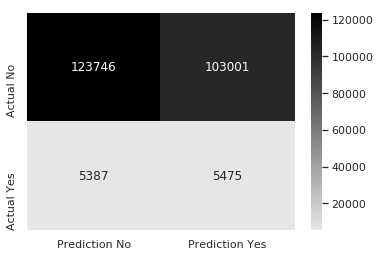

In [0]:
# creating a confusion matrix to understand the classification
conf = metrics.confusion_matrix(y_train, y_pred_train)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(conf,cmap = cmap,xticklabels=['Prediction No','Prediction Yes'],yticklabels=['Actual No','Actual Yes'], annot=True,
            fmt='d')

In [0]:
# Creating Classification Report

cr = metrics.classification_report(y_train, y_pred_train)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.55      0.70    226747
           1       0.05      0.50      0.09     10862

    accuracy                           0.54    237609
   macro avg       0.50      0.52      0.39    237609
weighted avg       0.92      0.54      0.67    237609



### Decision Tree with gini and entropy both

In [0]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'gini',max_depth = 10, min_samples_leaf =3, random_state=101)

In [0]:
model_fit=dt.fit(X_train, y_train)

In [0]:
# now applying our learnt model on test and also on train data

y_pred_test = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

In [0]:
from sklearn.metrics import confusion_matrix as cm
cm=cm(y_train, y_pred_train)
cm

array([[226669,     78],
       [ 10645,    217]])

In [0]:
print(y_pred_test)

[0 0 0 ... 0 0 0]


In [0]:
y_pred["is_click"] = pd.DataFrame(y_pred_test) 

In [0]:
y_pred["is_click"].value_counts()

0    90548
1      127
Name: is_click, dtype: int64

## Conclusion: 127 times ad is clicked during 2018/12/12 – 2018/12/18 

In [0]:
y_pred.head()

,0,is_click
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [0]:
submission=pd.concat([X_test,y_pred], axis=1)

In [0]:
submission.head()

,user_id,app_code,is_4G,os_version_latest,os_version_old,Hour,Month,day,Minute,Second,0,is_click
0,44754,127,1,1,0,7,12,3,44,0,0,0
1,29656,44,0,1,0,7,12,3,45,0,0,0
2,25234,296,1,1,0,7,12,3,46,0,0,0
3,22988,207,1,1,0,7,12,3,47,0,0,0
4,35431,242,1,1,0,7,12,3,48,0,0,0


In [0]:
from google.colab import files
submission.to_csv('submission.csv')
files.download('submission.csv')

#### DT with entropy

In [0]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 10, min_samples_leaf =3, random_state=101)

In [0]:
model_fit=dt.fit(X_train, y_train)

In [0]:
# now applying our learnt model on test and also on train data

y_pred_test = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

In [0]:
from sklearn.metrics import confusion_matrix as cm
cm=cm(y_train, y_pred_train)
cm

array([[226683,     64],
       [ 10694,    168]])

In [0]:
 
y_pred["is_click"] = pd.DataFrame(y_pred_test) 

In [0]:
y_pred["is_click"].value_counts()

0    90582
1       93
Name: is_click, dtype: int64